# Statistical Testing

Keep in mind that these are preliminary findings, because filtering predictors based on their p-values on the entire dataset leads to information leakage, because you see the target values before the model is even trained. Hence, the results of these tests will be used only as guidance, not as an only way to filter and choose useful predictors before modeling. The proper way of determining whether or not a predictor is useful comes from model training, cross-validation and model tuning stages, where the target is used only within the training folds. 


In the EDA stage, I have seen the impact of certain features. I want to statistically confirm or reject my findings. First, I will turn my attention to the target variable. `'Anxiety Level (1-10)'` has a slight right skew, I will first find it's skew and kurtosis, and based on this result decide whether to use parametric or non-parametric statistical tests.


In [19]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import shapiro, kruskal, spearmanr, pearsonr, mannwhitneyu, ttest_ind
import scikit_posthocs as sp

In [27]:
anxiety_data = pd.read_csv("enhanced_anxiety_dataset.csv")
anxiety_data.head()


,Age,Gender,Occupation,Sleep Hours,Physical Activity (hrs/week),Caffeine Intake (mg/day),Alcohol Consumption (drinks/week),Smoking,Family History of Anxiety,Stress Level (1-10),Heart Rate (bpm),Breathing Rate (breaths/min),Sweating Level (1-5),Dizziness,Medication,Therapy Sessions (per month),Recent Major Life Event,Diet Quality (1-10),Anxiety Level (1-10)
0,29,Female,Artist,6.0,2.7,181,10,Yes,No,10,114,14,4,No,Yes,3,Yes,7,5.0
1,46,Other,Nurse,6.2,5.7,200,8,Yes,Yes,1,62,23,2,Yes,No,2,No,8,3.0
2,64,Male,Other,5.0,3.7,117,4,No,Yes,1,91,28,3,No,No,1,Yes,1,1.0
3,20,Female,Scientist,5.8,2.8,360,6,Yes,No,4,86,17,3,No,No,0,No,1,2.0
4,49,Female,Other,8.2,2.3,247,4,Yes,No,1,98,19,4,Yes,Yes,1,No,3,1.0


In [4]:
# calculate the skew and kurtosis of the target variable 'Anxiety Level'
target = anxiety_data['Anxiety Level (1-10)']

# calculate skewness
skew = target.skew()

# calculate kurtosis
kurtosis = target.kurt()

print("Anxiety level skewness:", skew)
print("Anxiety level kurtosis:", kurtosis)

Anxiety level skewness: 1.0439964647889457
Anxiety level kurtosis: 0.950053926739526


`'Anxiety Level (1-10)'` has a skewness of $1.05$, which is moderate skew, but it doesn't represent a large issue for larger data size. Kurtosis is positive with the value $0.95$, meaning it has a higher peak and heavier tails compared to the normal distribution(which has kurtosis $0$). In theory, non-parametric tests like **Spearman's correlation**, **Kruskal - Wallis** and **Mann-Whitney U** should be used to test the data. However, since there are many rows in the data, $11000$ to be precise, I will be able to use parametric tests like **ANOVA**, **Pearson's correlation** and **t-test** because of the **central limit theorem (CLT)**.

According to CLT, even if the data itself is not normally distributed, for a large enough sample the sample statistics (like means, medians, proportions etc.) converge towards normal distribution. Despite this, it is good practice to check the model residuals - if they are non-normal, it is better to use more robust methods and tests. 

For the detailed testing, I will use tests for both skewed and non-skewed data, and compare the results to check whether the fact that the data is large helps correct for skew. 

The strength of linear correlation:
* Pearson correlation: for approximately normal variables, less robust to skew.
* Spearman correlation: for skewed or ordinal variables, more robust to non-normality and outliers.

Comparing anxiety levels between two groups:
* Independent samples t-test: compares means of 2 groups (parametric).
* Mann-Whitney U: compares medians of 2 groups (non-parametric).

Comparing anxiety levels between three or more groups:
* One-way ANOVA test: compares means across multiple groups (parametric).
* Kruskal - Wallis test: compares medians across multiple groups (non-parametric), more robust to skew because it's more appropriate for ordinal or non-normal data.
* Tukey's HSD test: post-hoc test for ANOVA to determine which groups significantly differ.
* Dunn’s test: post-hoc test for Kruskal-Wallis

## The strength of linear relationship

From the EDA notebook, **stress levels**, **therapy sessions per month**, **sleep hours** and **caffeine intake** are the strongest predictors. First, I will calculate skew and curtosis for these predictors, and then the linear coefficients. Although the Pearson's coefficient was already computed there for these columns, I will calculate it here again for comparison purposes, alongside Spearman's.

In [5]:
strongest_predictors = ['Stress Level (1-10)', 'Therapy Sessions (per month)', 'Sleep Hours', 'Caffeine Intake (mg/day)']
target = 'Anxiety Level (1-10)'

def calculate_skew_kurtosis(df, col):
    # calculate skewness
    skew = df[col].skew()

    # calculate kurtosis
    kurtosis = df[col].kurtosis()

    # print the results
    print(f"For variable '{col}', we have:")
    print(f"\tSkew: {skew:.4f}")
    print(f"\tKurtosis: {kurtosis:.4f}")
    print("-"*100)

for predictor in strongest_predictors:
    calculate_skew_kurtosis(anxiety_data, predictor)

For variable 'Stress Level (1-10)', we have:
	Skew: -0.1609
	Kurtosis: -1.2557
----------------------------------------------------------------------------------------------------
For variable 'Therapy Sessions (per month)', we have:
	Skew: 1.0351
	Kurtosis: 0.5869
----------------------------------------------------------------------------------------------------
For variable 'Sleep Hours', we have:
	Skew: -0.2245
	Kurtosis: -0.0476
----------------------------------------------------------------------------------------------------
For variable 'Caffeine Intake (mg/day)', we have:
	Skew: 0.3239
	Kurtosis: -0.7014
----------------------------------------------------------------------------------------------------


Stress Levels has a slight left skew, and moderate negative kurtosis (lighter tails and smaller height than for normal distribution). In other words, the distribution of "Stress Level" has fewer extreme values (outliers) than a normal distribution. Hence, it might not require any transformation for most statistical analyses.

Therapy Sessions (per month) has a moderate right-skewed distribution, and a positive kurtosis with fewer extreme values than a normal distribution.  Because of this, the variable should be transformed if used in models such as linear regression.

Sleep Hours is nearly symmetric with a light left-tailed distribution. No transformation is likely needed. 

Caffeine Intake has a slightly right skew, and it has a light-tailed distribution with fewer outliers. It would potentially benefit from certain transformations if used in linear regression.

In [6]:
def linear_strength(df, col1, col2):

    # calculate pearson's coefficient and its p-value
    r, p_pearson = pearsonr(df[col1], df[col2])

    # calculate spearman's coefficient and its p-value
    rho, p_spearman = spearmanr(df[col1], df[col2])

    print(f"For a predictor '{col1}'")
    print(f"\tSpearman's correlation: {rho:.2f}", f"; p-value: {p_spearman:.6f}")
    print(f"\tPearson's correlation: {r:.2f}", f"; p-value: {p_pearson:.6f}")
    print("-"*100)

for predictor in strongest_predictors:
    linear_strength(anxiety_data, predictor, target)

For a predictor 'Stress Level (1-10)'
	Spearman's correlation: 0.72 ; p-value: 0.000000
	Pearson's correlation: 0.67 ; p-value: 0.000000
----------------------------------------------------------------------------------------------------
For a predictor 'Therapy Sessions (per month)'
	Spearman's correlation: 0.33 ; p-value: 0.000000
	Pearson's correlation: 0.52 ; p-value: 0.000000
----------------------------------------------------------------------------------------------------
For a predictor 'Sleep Hours'
	Spearman's correlation: -0.35 ; p-value: 0.000000
	Pearson's correlation: -0.49 ; p-value: 0.000000
----------------------------------------------------------------------------------------------------
For a predictor 'Caffeine Intake (mg/day)'
	Spearman's correlation: 0.28 ; p-value: 0.000000
	Pearson's correlation: 0.35 ; p-value: 0.000000
----------------------------------------------------------------------------------------------------


For Stress Level, coefficients have a similar value, so either of them can be safely used in modeling. Therapy Sessions has a larger skew, hence Spearman's correlation coefficient would be preffered. For Sleep Hours, since it is barely skewed, Pearson's coefficient will be used. Finally, for Caffeine Intake, both Spearman and Pearson could work. Hence, the following coefficients quantify the strength of the linear relationship between predictors and target:

* `Stress Level (1-10)` and `Anxiety Level (1-10)`: $0.67$
* `Therapy Sessions (per month)` and `Anxiety Level`: $0.33$
* `Sleep Hours` and `Anxiety Level`: $-0.49$
* `Caffeine Intake (mg/day)` and `Anxiety Level`: $0.35$

## Comparing anxiety levels between two groups

First, I will determine which of the categorical variables in the data have only two groups, and then I will run an independent samples t-test and
Mann-Whitney U test.

In [7]:
# get a dataframe with only categorical variables
categorical_variables = anxiety_data.select_dtypes(include = ['object'])

# get the number of unique values per column
unique_counts = categorical_variables.nunique()

# isolate only columns with 2 unique values
vars_2_categories = unique_counts[unique_counts == 2].index.tolist()
print(f"Categorical cols with 2 values:", vars_2_categories)

Categorical cols with 2 values: ['Smoking', 'Family History of Anxiety', 'Dizziness', 'Medication', 'Recent Major Life Event']


In [8]:
# get the binary values and their counts
for col in vars_2_categories:
    print(f"\nValue counts for '{col}':")
    print(anxiety_data[col].value_counts())
    print("-"*100)


Value counts for 'Smoking':
Smoking
Yes    5779
No     5221
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------

Value counts for 'Family History of Anxiety':
Family History of Anxiety
Yes    5847
No     5153
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------

Value counts for 'Dizziness':
Dizziness
Yes    5672
No     5328
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------

Value counts for 'Medication':
Medication
Yes    5666
No     5334
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------

Value counts for 'Recent Major Life Event':
Recent Major Life Event
Yes    5623
No     5377
Name: count, dtype: int64
-----------------------------------------------------------------------------------

Since all of the binary categorical variables have 'Yes' or 'No' answers, I will explicitly define groups for statistical tests to follow, as:

In [9]:
# a function to compute t-statistic and mannwhitney
def compute_t_mannwhitney(df, categorical_col, target):

    # get the groups (explicitly for "Yes" and "No" values)
    group_yes = df[df[categorical_col] == "Yes"][target]
    group_no = df[df[categorical_col] == "No"][target]


    # calculate t-statistic and its p-value
    tstat, pvalue = ttest_ind(group_yes, group_no, alternative='two-sided', equal_var=False)

    # compute mann-whitney U statistic
    u_stat, p_mw = mannwhitneyu(group_yes, group_no, alternative='two-sided')

    # print the results
    print(f"For a predictor '{categorical_col}':")
    print(f"\tStudent's t-statistic: {tstat:.2f}", f"; p-value: {pvalue:.6f}")
    print(f"\tMann-Whitney U-statistic: {u_stat:.2f}", f"; p-value: {p_mw:.6f}")
    print("-"*100)

for predictor in vars_2_categories:
    compute_t_mannwhitney(anxiety_data, predictor, 'Anxiety Level (1-10)')

For a predictor 'Smoking':
	Student's t-statistic: 8.68 ; p-value: 0.000000
	Mann-Whitney U-statistic: 16062694.50 ; p-value: 0.000000
----------------------------------------------------------------------------------------------------
For a predictor 'Family History of Anxiety':
	Student's t-statistic: 20.69 ; p-value: 0.000000
	Mann-Whitney U-statistic: 18008295.00 ; p-value: 0.000000
----------------------------------------------------------------------------------------------------
For a predictor 'Dizziness':
	Student's t-statistic: 9.86 ; p-value: 0.000000
	Mann-Whitney U-statistic: 16216366.00 ; p-value: 0.000000
----------------------------------------------------------------------------------------------------
For a predictor 'Medication':
	Student's t-statistic: 5.95 ; p-value: 0.000000
	Mann-Whitney U-statistic: 15900835.50 ; p-value: 0.000001
----------------------------------------------------------------------------------------------------
For a predictor 'Recent Major Li

Both t-tests and Mann-Whitney U tests are showing extremely small p-values. This strongly suggests that there is a statistically significant difference in the numeric outcome between the two groups of each predictor. In other words, these predictors are very likely associated with the outcome. However, this is misleading - because the sample size is large, even small differences become statistically significant. Hence, I want to standardize both t-statistic and U-statistic so that I can compare the effect of each predictor on the target in a way that reflects the magnitude of the difference, not just statistical significance. In other words, I want to determine whether a statistically significant result is also meaningful in real-world terms. For, this I will use standardized Cohen's d (for a t-test) Rank-Biserial correlation (for a Mann-Whitney's U-test). I will write a new function, which calculates the effect size, keeping in mind two important formulas for standardization:

1. **Cohen's d (for a t-test)**: the difference between two means divided by a standard deviation for the data.
$$d = \frac{\bar{x}_1 - \bar{x}_2}{s}$$
, where $s$ - pooled standard deviation, defined as:

$$s = \sqrt{\frac{(n_1 - 1)s_1^2 + (n_2 - 1)s_2^2}{n_1 + n_2 - 2}}$$

2. **Rank-Biserial correlation (Mann-Whitney U-test)**: finds the correlation between dichotomous (binary) nominal data and ordinal (ranked) data. In  other words,  it is a way to describe how strong the difference is between two groups when after Mann-Whitney U-test. It has values from $-1$ to $1$, where $0$ indicates no difference between groups.

$$r = 1-\frac{2U}{n_1 n_2} $$

In [10]:
def effect_sizes(df, categorical_col, outcome):
    
    # get the groups (explicitly for "Yes" and "No" values)
    group_yes = df[df[categorical_col] == "Yes"][target]
    group_no = df[df[categorical_col] == "No"][target]

    # get the number of entries for each group
    n1 =len(group_yes)
    n2 =len(group_no)
    
    # calculate Cohen's d (from the formula above)
    mean_diff = group_yes.mean() - group_no.mean()
    s_pooled = np.sqrt(((n1-1)*group_yes.std(ddof=1)**2 + (n2-1)*group_no.std(ddof=1)**2) / (n1+n2-2))
    cohen_d = mean_diff / s_pooled
    
    # Rank-Biserial correlation for Mann-Whitneyu (from the formula above)
    U, p_mw = mannwhitneyu(group_yes, group_no, alternative='two-sided')
    rank_biserial = (2*U)/(n1*n2) - 1  # -1 to 1
    prob_X_greater_Y = U / (n1*n2)     # 0-1 probability

    print(f"For a predictor '{categorical_col}':")
    print(f"\tCohen's d value: {cohen_d:.3f}")
    print(f"\tRank-biserial correlation value: {rank_biserial:.3f}, P(X>Y) = {prob_X_greater_Y:.3f}")
    print("-"*60)

# Example usage: compute for multiple predictors
vars_2_categories = ['Smoking', 'Family History of Anxiety', 'Dizziness', 'Medication', 'Recent Major Life Event']
outcome_var = 'Anxiety Level (1-10)'  # replace with your numeric outcome column

for predictor in vars_2_categories:
    effect_sizes(anxiety_data, predictor, outcome_var)

For a predictor 'Smoking':
	Cohen's d value: 0.164
	Rank-biserial correlation value: 0.065, P(X>Y) = 0.532
------------------------------------------------------------
For a predictor 'Family History of Anxiety':
	Cohen's d value: 0.390
	Rank-biserial correlation value: 0.195, P(X>Y) = 0.598
------------------------------------------------------------
For a predictor 'Dizziness':
	Cohen's d value: 0.187
	Rank-biserial correlation value: 0.073, P(X>Y) = 0.537
------------------------------------------------------------
For a predictor 'Medication':
	Cohen's d value: 0.113
	Rank-biserial correlation value: 0.052, P(X>Y) = 0.526
------------------------------------------------------------
For a predictor 'Recent Major Life Event':
	Cohen's d value: 0.157
	Rank-biserial correlation value: 0.058, P(X>Y) = 0.529
------------------------------------------------------------


The $P(X>Y)$ value from the rank-biserial shows the probability that a randomly selected individual from one group has a higher outcome than a randomly selected individual from the other group. For this dataset, it is the probability that a randomly chosen person from the “Yes” group has a higher anxiety score than a randomly chosen person from the “No” group. Across predictors, this ranges from about $50 \%$ to $60 \%$  chance that who answered 'Yes' has a higher anxiety score than someone who answered 'No'.

For Cohen's d, the values for 'Smoking', 'Dizziness', 'Medication' and 'Recent Major Life Event' are all positive with values $<0.2$, indicating small effect on anxiety levels. For 'Family History of Anxiety', with a value of $0.39$, this is a small to moderate effect on anxiety levels when you compare both categories. Hence, those with a family history tend to have somewhat higher anxiety scores than those without it, while for other variables there is anxiety leves are only slightly higher for individuals in the 'Yes' category.

Rank-biserial correlation value tells how much the distributions of anxiety differ between the two groups, based on ranks (not mean values). For 'Smoking', 'Dizziness', 'Medication' and 'Recent Major Life Event' rank-biserial correlation values are positive with values $<0.08$, which means that people with those issues report just slightly higher anxiety than those in the 'No' category. For 'Family History of Anxiety' the coefficient is about $0.2$, meaning that people with a family history are somewhat more likely to report higher anxiety.

In summary, the conclusion is the same for both metrics: while most predictors show only minor differences, with individuals who answered 'Yes' having only slightly higher anxiety, family history of anxiety is the most meaningful binary categorical variable which contributes to higher anxiety levels.


## Comparing anxiety levels between three or more groups

To compare anxiety levels for categorical variables with 3 or more groups, I will first check the assumptions for the tests to see whether to do a parametric (ANOVA) or non-parametric (Kruskal - Wallis) test. For **ANOVA**, the assumptions are:

* **Independence of observations**: already fullfilled, because the rows are independent
* **Normality of the residuals**: needs to be checked using a q-q plot, histogram of residuals or a Shapiro-Wilk test
* **Homogeneity of variances (homoscedasticity)**: needs to be checked using residuals vs. fitted values plot


The target 'Anxiety Level (1-10)' is technically an ordinal variable, not continuous numerical, which is not ideal for ANOVA. Because of that, the residuals can behave strangely, but checking them can still be informative. In this case, Kruskal-Wallis test is more appropriate for an ordinal target variable, because it uses ranks rather than raw values.

First, I will do one-way ANOVA test followed by post-hoc Tukey's HSD test to confirm which groups differ. In order to check the assumptions, the model has to be fitted first, and the results are interpreted only after the assumption check. Then, if the normality or homoscedasticity assumption is violated, I will do Kruskal - Wallis test followed by its post-hoc Dunn test because they are more robust to ordinal data.

### One-way ANOVA and Tukey's HSD

First, I will isolate only the predictors with $3$ or more groups. The formulations of the null $H_0$ and the alternative hypothesis $H_1$ for ANOVA are:

* $H_0$ = the mean values are the same across categories.
* $H_1$ = the mean values differ across categories.

In [11]:
# isolate only columns with 3 unique values
vars_3_categories = unique_counts[unique_counts >= 3].index.tolist()
print(f"Categorical cols with 3 or more values:", vars_3_categories)

Categorical cols with 3 or more values: ['Gender', 'Occupation']


In [12]:
# get the categorical values and their count
for col in vars_3_categories:
    print(f"\nValue counts for '{col}':")
    print(anxiety_data[col].value_counts())
    print(f"Total number groups: {anxiety_data[col].nunique()}")
    print("-"*100)


Value counts for 'Gender':
Gender
Female    3730
Male      3657
Other     3613
Name: count, dtype: int64
Total number groups: 3
----------------------------------------------------------------------------------------------------

Value counts for 'Occupation':
Occupation
Musician      892
Artist        888
Student       878
Nurse         861
Chef          858
Doctor        842
Other         840
Freelancer    838
Engineer      833
Scientist     832
Athlete       822
Lawyer        809
Teacher       807
Name: count, dtype: int64
Total number groups: 13
----------------------------------------------------------------------------------------------------


I have $3$ possible values for 'Gender', and $13$ for occupation. The sample size is similar for each group, about $3600$ per group for  Gender, and on average $850$ for Occupation.

In [13]:
# one-way ANOVA for gender
model_gender = smf.ols(formula = 'Q("Anxiety Level (1-10)") ~ C(Gender)', data=anxiety_data).fit()
anova_table_gender = sm.stats.anova_lm(model_gender, typ=2) 
pd.DataFrame(anova_table_gender)
# model_gender.summary() - more detailed report

,sum_sq,df,F,PR(>F)
C(Gender),0.222895,2.0,0.024733,0.97557
Residual,49551.892651,10997.0,NaN,NaN


In [14]:
# one-way ANOVA for occupation
model_occupation = smf.ols(formula = 'Q("Anxiety Level (1-10)") ~ C(Occupation)', data=anxiety_data).fit()
anova_table_occupation = sm.stats.anova_lm(model_occupation, typ=2) 
pd.DataFrame(anova_table_occupation)
# model_occupation.summary() - more detailed report

,sum_sq,df,F,PR(>F)
C(Occupation),273.436713,12.0,5.080374,1.596908e-08
Residual,49278.678833,10987.0,NaN,NaN


The relevant statistic is the **F-statistic** for ANOVA test, and it is  based on the ratio of the variance across group mean to the variance due to residual error (the higher the ratio, the more significant the result). 

With an F-statistic of $0.22$ for Gender, and its' p-value of $0.97$, there isn't statistically significant difference in anxiety levels across different genders. Although the boxplot from the EDA stage showed that there are higher anxiety levels for people who identify as the 'Other' gender, ANOVA showed that this isn't true and anxiety levels are similar for 'Male', 'Female' and  'Other'. Hence, I don't need to check the ANOVA assumptions for the Gender.

When it comes to Occupation, its' F-statistic is about $5$, with an extremely small p-value, leading to the conclusion that the result is statistically significant. ANOVA just states that there are differences between groups, and to determine which groups exactly differ I will now use the Tukey's HSD test, with a significance level of $\alpha = 0.05$ (meaning 5% significance evel).

Hence, the null hypothesis cannot be rejected for Gender, while it is rejected for Occupation - meaning that the result is statistically significant. Now, I will check the ANOVA assumptions to make sure these conclusions are valid.

First, I want to check **residuals normality assumption** using **quantile-quantile plot** and **histogram of residuals**. I will quickly calculate the mean values and corresponding standard deviations for different occupations to get a sense if there could be any violation (i.e. if standard deviations differ too much). Then, I will calculate the model residuals, and do the plots. 



In [15]:
# check the means and standard deviation for each occupation
group_means_std = anxiety_data.groupby('Occupation', observed=False)['Anxiety Level (1-10)'].agg(['mean', 'median' ,'std']).sort_values('mean', ascending=False)
group_means_std

,mean,median,std
Occupation,,,
Lawyer,4.206428,4.0,2.064710
Doctor,4.199525,4.0,2.174460
Engineer,4.138055,4.0,2.055458
Scientist,4.062500,4.0,2.087943
Freelancer,3.952267,4.0,2.152515
Student,3.883827,4.0,2.142620
Athlete,3.871046,4.0,2.146388
Nurse,3.854820,4.0,2.142280
Chef,3.840326,3.0,2.114882


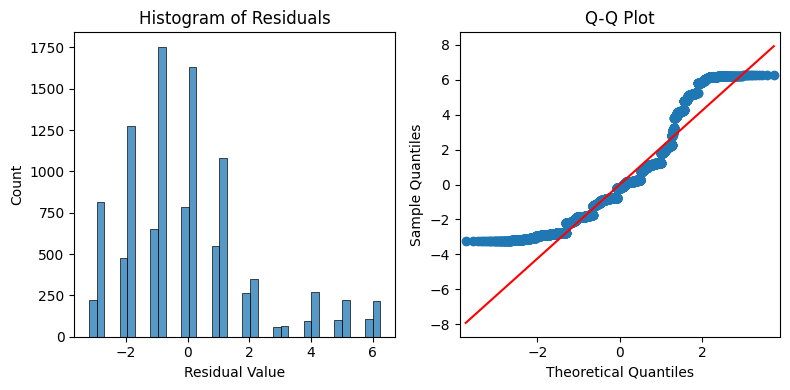

In [20]:
# calculate the residuals
residuals = model_occupation.resid

# create a 1x2 plot figure.
fig, axes = plt.subplots(1, 2, figsize = (8,4))

# create a histogram of residuals
sns.histplot(residuals, ax=axes[0])
axes[0].set_xlabel("Residual Value")
axes[0].set_title("Histogram of Residuals")

# create a Q-Q plot of the residuals
sm.qqplot(residuals, line='s',ax = axes[1])
axes[1].set_title("Q-Q Plot")

plt.tight_layout()
plt.show()

In [21]:
# calculate skewness of residuals
skew = residuals.skew()
print(f"The skew of residuals: {skew}")

The skew of residuals: 1.0537562414454904


A skew of residuals $1.05$ indicates moderate right skew), and this skew is confirmed on a histogram and quantile-quantile plot. Hence, since the normality assumption is violated, a better test would be Kruskal - Wallis, which is more robust to non-normality. For completeness, I will now check the **homoscedasticity assumption** using a **fitted values vs residuals plot**:

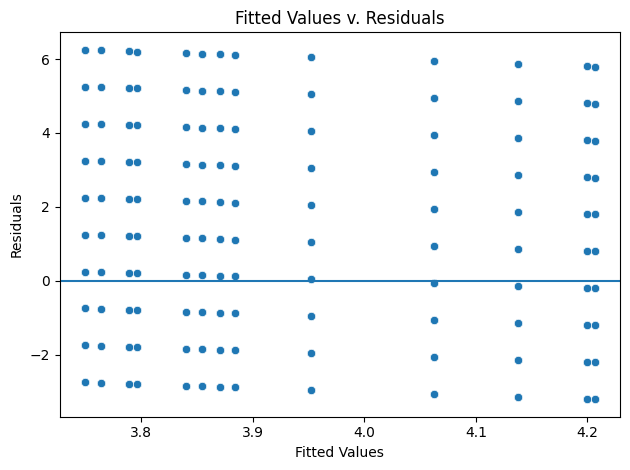

In [22]:
# plot the fitted values vs residuals
sns.scatterplot(x = model_occupation.fittedvalues, y = model_occupation.resid)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Fitted Values v. Residuals")
plt.axhline(0)  # helps with the visualization below and above 0
plt.tight_layout()
plt.show()

First, I will compute and display the mean values for the Occupation column, and then I will perform Tukey's HSD to check their statistical significance. Note that the Tukey's test is not ideal here, because the ANOVA assumptions are violated and the results could be misleading. However, I will do it for purely demonstrative purposes, and compare it later to Dunn's test which is more adequate for an ordinal outcome such as Anxiety Level.

In [173]:
# tukey's hsd for occupation
tukey_occupation = pairwise_tukeyhsd(endog=anxiety_data['Anxiety Level (1-10)'], groups=anxiety_data['Occupation'], alpha=0.05)
tukey_occupation.summary()

C:\Users\Ana\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\integrate\_quadpack_py.py:1260: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


group1,group2,meandiff,p-adj,lower,upper,reject
Artist,Athlete,0.0749,0.9999,-0.2597,0.4095,False
Artist,Chef,0.0442,1.0,-0.2868,0.3751,False
Artist,Doctor,0.4034,0.0042,0.0708,0.7359,True
Artist,Engineer,0.3419,0.0386,0.0084,0.6753,True
Artist,Lawyer,0.4103,0.0038,0.0743,0.7463,True
Artist,Musician,-0.0069,1.0,-0.3347,0.3208,False
Artist,Nurse,0.0586,1.0,-0.272,0.3893,False
Artist,Other,-0.0319,1.0,-0.3646,0.3009,False
Artist,Scientist,0.2663,0.274,-0.0672,0.5999,False
Artist,Student,0.0877,0.9994,-0.2414,0.4167,False


For positive values of the mean difference `meandiff`, it means that `group1` has higher mean anxiety levels than `group2`, whereas it's the opposite for negative values. I am interested in values where the hypothesis was rejected, `reject = True`. 

In [128]:
# convert to a DataFrame to isolate rows with only reject = True
tukey_df = pd.DataFrame(data = tukey_occupation._results_table.data[1:], columns = tukey_occupation._results_table.data[0])
rejected = tukey_df[tukey_df['reject'] == True]
rejected

,group1,group2,meandiff,p-adj,lower,upper,reject
2,Artist,Doctor,0.4034,0.0051,0.0658,0.7409,True
3,Artist,Engineer,0.3419,0.0450,0.0034,0.6804,True
5,Artist,Lawyer,0.4103,0.0046,0.0692,0.7513,True
23,Chef,Doctor,0.3592,0.0277,0.0188,0.6996,True
26,Chef,Lawyer,0.3661,0.0249,0.0222,0.7100,True
36,Doctor,Musician,-0.4103,0.0038,-0.7475,-0.0731,True
37,Doctor,Nurse,-0.3447,0.0434,-0.6848,-0.0046,True
38,Doctor,Other,-0.4352,0.0018,-0.7774,-0.0930,True
41,Doctor,Teacher,-0.4498,0.0012,-0.7955,-0.1041,True
44,Engineer,Musician,-0.3488,0.0358,-0.6869,-0.0107,True


Mean anxiety scores range roughly from $3.7$ to $4.2$, and the STDs are from $2.0$ to $2.2$, so there is not a large difference in varianecs. The difference `upper - lower` represents the $95 \%$ confidence interval for the data. Here are all pairs of occupations which have statistically different mean values of anxiety levels. When I look at the computed means for each occupation, the top  5 are Lawyer, Doctor, Engineer, Scientist and Freelancer. However, I see that the Tukey's HSD test didn't give enough evidence that the means differ, meaning that for example there is no statistically significant difference between Artist and Freelancer, Artist and Scientist, and so on for other variables. 

In conclusion, the Tukey's HSD test showed that even though occupation influences anxiety levels, the effect is not consistent across pairs. Therefore, occupation might be a useful predictor when building models. Again, it was performed just for informative purposes, as the ANOVA's assumption are violated, and the results that I will focus on and report will be the ones from a Dunn's test.

### Kruskal–Wallis H-Test and Dunn's test

Since the data is ordinal and ANOVA assumptions are violated. Gender didn't show statistically significant differences between group means, so I will do the Kruskal-Wallis and Dunn's test only for the Occupation variable:

In [162]:
# get occupations
occupations = anxiety_data['Occupation'].unique()

# create an empty list to store results for each occupation
occ_list = []

# get anxiety levels for each occupation
for occ in occupations:
    anxiety_for_occ = anxiety_data[anxiety_data['Occupation'] == occ]['Anxiety Level (1-10)'].values
    occ_list.append(anxiety_for_occ)


# Run Kruskal-Wallis test
stat, p_value = kruskal(*occ_list)

print(f"Kruskal-Wallis H-statistic: {stat:.4f}")
print(f"p-value: {p_value:.6f}")

if p_value < 0.05:
    print("Result: There are significant differences between occupations.")
else:
    print("Result: There are no significant differences between occupations.")


Kruskal-Wallis H-statistic: 93.7189
p-value: 0.000000
Result: There are significant differences between occupations.


The Kruskal-Wallis test shows a significant difference between occupations, with a H-statistic of about $94$ and a p-value of $0$, which indicates that at least one of the occupations differs from others in anxiety median value. To determine which groups differ exactly, I will follow this up with a Dunn test, which gives the p-values for the group pairs:



In [166]:
# Post-hoc Dunn test with Bonferroni correction
posthoc_dunn = sp.posthoc_dunn(anxiety_data, val_col='Anxiety Level (1-10)', group_col='Occupation', p_adjust='bonferroni')
dunn_df = pd.DataFrame(posthoc_dunn)
dunn_df

,Artist,Chef,Musician,Other,Teacher,Nurse,Engineer,Scientist,Student,Athlete,Doctor,Lawyer
Artist,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.001101,0.050663,1.000000,1.000000,0.000527,0.000047
Chef,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.010610,0.296895,1.000000,1.000000,0.005572,0.000637
Musician,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000411,0.023002,1.000000,1.000000,0.000190,0.000015
Other,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000038,0.003107,1.000000,1.000000,0.000016,0.000001
Teacher,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000365,0.019119,1.000000,1.000000,0.000171,0.000015
Nurse,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.031625,0.693831,1.000000,1.000000,0.017364,0.002235
Engineer,0.001101,0.010610,0.000411,0.000038,0.000365,0.031625,1.000000,1.000000,0.087879,0.026516,1.000000,1.000000
Scientist,0.050663,0.296895,0.023002,0.003107,0.019119,0.693831,1.000000,1.000000,1.000000,0.587210,1.000000,1.000000
Student,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.087879,1.000000,1.000000,1.000000,0.050307,0.007247
Athlete,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.026516,0.587210,1.000000,1.000000,0.014560,0.001881


In [170]:
# set the significance level
alpha = 0.05

# loop over the upper triangle to get only values with p<0.05
for i, group1 in enumerate(dunn_df.index):
    for j, group2 in enumerate(dunn_df.columns):
        if j > i:  # only upper triangle
            p_val = dunn_df.loc[group1, group2]
            if p_val < alpha:
                print(f"{group1} vs {group2}: p = {p_val:.4f}")

Artist vs Engineer: p = 0.0011
Artist vs Doctor: p = 0.0005
Artist vs Lawyer: p = 0.0000
Chef vs Engineer: p = 0.0106
Chef vs Doctor: p = 0.0056
Chef vs Lawyer: p = 0.0006
Musician vs Engineer: p = 0.0004
Musician vs Scientist: p = 0.0230
Musician vs Doctor: p = 0.0002
Musician vs Lawyer: p = 0.0000
Other vs Engineer: p = 0.0000
Other vs Scientist: p = 0.0031
Other vs Doctor: p = 0.0000
Other vs Lawyer: p = 0.0000
Teacher vs Engineer: p = 0.0004
Teacher vs Scientist: p = 0.0191
Teacher vs Doctor: p = 0.0002
Teacher vs Lawyer: p = 0.0000
Nurse vs Engineer: p = 0.0316
Nurse vs Doctor: p = 0.0174
Nurse vs Lawyer: p = 0.0022
Engineer vs Athlete: p = 0.0265
Student vs Lawyer: p = 0.0072
Athlete vs Doctor: p = 0.0146
Athlete vs Lawyer: p = 0.0019


The significance level is set to $\alpha = 0.05$. The cells in which p-value $<0.05$ indicate a statistically significant result, meaning the difference in group medians is significant and I can reject the null hypothesis.  The Dunn showed that there is an effect for some occupations on anxiety level, but this effect is not consistent across pairs. From the table containing mean values and STD's, it can be seen that the largest difference in mean anxiety levels is $4.21 - 0.37 \approx 0.46$. The medians are either $3$ or $4$ for all occupations. So, across all occupations the difference in average anxiety is less than $0.5$, so less than half a point for the anxiety levels taking values from $1$ to $10$. For the median values, the difference is $1$ point across all occupations. Because of this insight, I assume that the Occupation column is, at best, a moderate predictor for anxiety levels.

## Key Takeaways

* Since both **Stress Levels** and **Sleep hours** have slight skews, with **Caffeine Intake** having a slightly stronger skew, the transformation of data is likely not needed. **Therapy Sessions** variable has a moderate right-skewed distribution, so it would potentially benefit from logarithmic transformation or box-cox.
* The strength of linear relationship for most important numerical predictors was investigated using **Pearson's** and **Spearman's** coefficients.
    * **Stress Level** has Pearson's coefficient $0.67$ (strong positive correlation with anxiety)
    * **Sleep Hours** has Pearson's coefficient $-0.49$ (moderately negative correlation with anxiety)
    * **Caffeine Intake** has Pearson's coefficient $0.35$ (moderately positive correlation with anxiety)
    * **Therapy Sessions per Month** has Spearman's coefficient $0.33$ (moderately positive, Spearman used because of skew)
* For binary categorical variables, both **t-test** and **Mann-Whitney U-test** showed extremely small p-values due to the large sample size ($11000$ rows). Hence, I computed **effect sizes** to inspect the significance in real-world data:
    * **Family History of Anxiety** has small-to-moderate effect (**Cohen’s d** $  = 0.39$)
    * **Smoking, Dizziness, Medication, Major Life Event**: have very small practical effects (**Cohen’s d** $< 0.2$)
* For multi-category variables, ANOVA and Kruskal–Wallis tests were applied, with **post-hoc Tukey’s HSD** and **Dunn’s tests** respectively. 

    * **Normality** and **homoscedasticity** assumptions of **ANOVA** are violated, hence **Kruskal-Wallis** is preffered and reported.
    * **Gender** shows no significant differences in anxiety levels
    * **Occupation** shows significant differences between some of the occupations, but not for others.

In conclusion, **Stress Levels**, **Sleep hours**, and **Family History of Anxiety** appear to be the main contributors to anxiety - individuals who experience more stress, sleep less and have a family history experience higher anxiety. Higher **daily caffeine intake** and larger number of **monthly therapy sessions** contributes to higher anxiety, with some occupations showing higher anxiety than others. Factors such as **smoking**, **experiecing dizziness**, **taking medication**, or **having a recent major life event** have only a minor impact on anxiety levels.

**Next Steps**:
* Transform data - scaling, box-cox, logarithmic or other transformations of predictors.
* Perform feature engineering, such as one-hot encoding for categorical variables.
